In [ ]:
!pip install qiskit
import qiskit
import math
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
# This program converts Bayesian networks into quantum circuits

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Below is code for representing a Bayesian network. Note that this program only works for networks with two-state nodes.

# The network is a directed, acyclic graph.
class network:
    def __init__(self, root_nodes, child_nodes):
        # Root nodes is a list of probabilities of the root nodes/events occurring independently.
        self.root_nodes = root_nodes
        # Child nodes is a list of lists of: tuples of list indices representing the parent nodes; a tuple of probabilities for each combination of
        # occurences of the parent nodes. The order of the probabilities counts up in binary from 0 to 2^n, where n is the number of parent nodes.
        self.child_nodes = child_nodes

    def find_child_probs(self):
        # Finds the probability of each child node occurring and returns them as a list.
        child_probs = [0]*len(self.child_nodes)
        children_found = [False]*len(self.child_nodes)
        root_num = len(self.root_nodes)
        def find_prob(node, node_index):
            # Finds the probability for a single child node.
            parent_probs = []
            for index in node[0]:
                # Find the parent node for the given index
                prob = None
                # Check if root or child node
                if index < root_num:
                    # Root node
                    prob = self.root_nodes[index]
                else:
                    # Child node
                    if children_found[index-root_num]:
                        prob = child_probs[index-root_num]
                    else:
                        prob = find_prob(self.child_nodes[index - root_num], index)

                assert prob != None
                parent_probs.append(prob)
            node_prob = 0
            for n, cond_prob in enumerate(node[1]):
                binary = bin(n)[2:].zfill(len(parent_probs))
                p = cond_prob
                for i, b in enumerate(binary):
                    if b == '1':
                        p *= parent_probs[i]
                    elif b == '0':
                        p *= 1 - parent_probs[i]
                node_prob += p

            children_found[node_index] = True
            return node_prob

        for child_index, child in enumerate(self.child_nodes):
            if not children_found[child_index]:
                child_probs[child_index] = find_prob(child, child_index)

        return child_probs

    # Translates the network to a corresponding quantum circuit, draws it, and calculates the child probabilities.
    def quantum_circuit(self, draw=True):
        qc = qiskit.QuantumCircuit(len(self.root_nodes) + len(self.child_nodes), len(self.child_nodes))
        root_num = len(self.root_nodes)
        for r, root in enumerate(self.root_nodes):
            if root == 1:
                qc.x(r)
            else:
                qc.ry(2*math.atan(math.sqrt(root/(1-root))), r)
        for c, child in enumerate(self.child_nodes):
            for b, prob in enumerate(child[1]):
                binary = bin(b)[2:].zfill(len(child[0]))
                for i, n in enumerate(binary):
                    if n == '0':
                        qc.x(child[0][i])
                if prob == 1:
                    qc.mcx(list(child[0]), c+root_num)

                else:
                    qc.mcry(2*math.atan(math.sqrt(prob/(1-prob))), list(child[0]), c+root_num)
                for i, n in enumerate(binary):
                        if n == '0':
                            qc.x(child[0][i])
                qc.barrier()
        for c in range(len(self.child_nodes)):
            qc.measure(c+root_num, c)
        if draw:
            print(qc)
        #if noise:
        #    provider = qiskit.IBMQ.load_account()
        #    backend = provider.get_backend('ibmq_vigo')
        #    noise_model = qiskit.NoiseModel.from_backend(backend)
        #    coupling_map = backend.configuration().coupling_map
        #    basis_gates = noise_model.basis_gates
        #    sim = qiskit.execute(qiskit.circ, qiskit.Aer.get_backend('qasm_simulator'),
        #         coupling_map=coupling_map,
        #         basis_gates=basis_gates,
        #         noise_model=noise_model).result()
        sim = qiskit.execute(qc, qiskit.BasicAer.get_backend('qasm_simulator'), shots=256)
        results = sim.result().get_counts()
        node_counts = [0]*len(self.child_nodes)
        total_counts = 0
        for result in results:
            total_counts += int(results[result])
            for i, b in enumerate(result):
                if b == '1':
                    node_counts[i] += results[result]
        node_counts = list(map(lambda c: c/total_counts, node_counts))
        node_counts.reverse()
        return (node_counts)


In [ ]:
# Create some sample networks
bn1 = network([0.8, 0.7], [[(0,1), (0.85, 0.7, 0.6, 0.9)]])
bn2 = network([0.1, 0.2], [[(0,1), (0, 0.5, 1, 1)]])
bn3 = network([0.2, 0.3, 0.4], [[(0,1,2), (0.1, 0.8, 0.2, 0.7, 0.3, 0.6, 0.4, 0.5)]])
bn4 = network([0.4, 0.6, 0.3, 0.7], [[(0,1), (0.5, 0.65, 0.35, 0.4)], [(2,3), (0.2, 0.4, 0.45, 0.15)], [(4,5), (0.5, 0.5, 0.2, 0.3)]])
bn5 = network([0.5], [[(0,), (0.2, 0.9)], [(0,), (0.55, 0.65)], [(1,2), (0.1, 0.3, 0.5, 0.7)], [(0,2), (0.6, 0.4, 0.2, 0)],
                      [(1,2,3), (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8)],
                      [(0,1,2,3), (0.3, 1, 0, 0.5, 0.7, 0.64, 0.21, 0, 0, 1, 0.89, 0.96, 0.4, 0.7, 0.25, 1)]])
print(bn1.find_child_probs(), bn2.find_child_probs(), bn3.find_child_probs(), bn4.find_child_probs(), bn5.find_child_probs())
bn1.quantum_circuit()
bn2.quantum_circuit()
bn3.quantum_circuit()
bn4.quantum_circuit()
bn5.quantum_circuit()

[0.7969999999999999] [0.19000000000000006] [0.3940000000000001] [0.506, 0.30999999999999994, 0.363886] [0.55, 0.6000000000000001, 0.44000000000000006, 0.27999999999999997, 0.484, 0.49604800000000004]
     ┌────────────┐┌───┐                         ┌───┐ ░      ┌───┐          »
q_0: ┤ Ry(2.2143) ├┤ X ├──■───────────────────■──┤ X ├─░──────┤ X ├───────■──»
     ├────────────┤├───┤  │                   │  ├───┤ ░      └───┘       │  »
q_1: ┤ Ry(1.9823) ├┤ X ├──■───────────────────■──┤ X ├─░──────────────────■──»
     ├────────────┤└───┘┌─┴─┐┌─────────────┐┌─┴─┐└───┘ ░ ┌─────────────┐┌─┴─┐»
q_2: ┤ Ry(1.1731) ├─────┤ X ├┤ Ry(-1.1731) ├┤ X ├──────░─┤ Ry(0.99116) ├┤ X ├»
     └────────────┘     └───┘└─────────────┘└───┘      ░ └─────────────┘└───┘»
c: 1/════════════════════════════════════════════════════════════════════════»
                                                                             »
«                          ┌───┐ ░                                          »
«q_0: ─────

[0.58984375, 0.6015625, 0.44140625, 0.2578125, 0.47265625, 0.43359375]

Classical (Actual): 0.7969999999999999
95% CI: (0.7937953215268911, 0.7969859284731089)
Mean: 0.795390625
Standard Deviation: 0.025695168791404155
Percent Error: 0.0020192910915933665



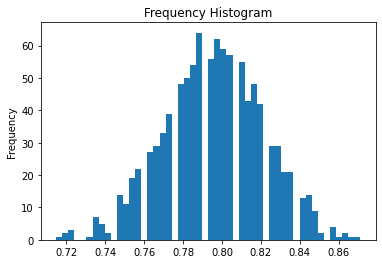

In [ ]:
# Accuracy and Precision
num = 1000
#bnl = [bn1, bn2, bn3, bn4, bn5]
bnl = [bn1]
for bn in bnl:
  classical = bn.find_child_probs()[0]
  avg = []
  for k in range(0,num):
    #res = bn.quantum_circuit(False)
    #if any(isinstance(p, list) for p in res):
    avg.append(bn.quantum_circuit(False)[0])
  #if any(isinstance(p, list) for p in avg): iter = len(avg)
  mean = sum(avg) / len(avg)
  stdev = np.std(avg)
  print("Classical (Actual): " + str(classical))
  print("95% CI: " + str(st.t.interval(alpha=0.95, df=len(avg)-1, loc=np.mean(avg), scale=st.sem(avg))))
  print("Mean: " + str(mean))
  print("Standard Deviation: " + str(stdev))
  print("Percent Error: " + str(np.abs((mean-classical)/classical))+ "\n")
  plt.hist(avg, bins=50)
  plt.gca().set(title='Frequency Histogram', ylabel='Frequency');